# Прогнозирование стоимости автомобиля по характеристикам


Образовательная платформа: SkillFactory

Специализация: Data Science

Группа: DST-37 и 38

Юнит 6. Проект 5: "Выбираем автомобиль правильно"


### Задача:

    Создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам для того, чтобы выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены).

### Метрика:

    MAPE (Mean Percentage Absolute Error) - средняя абсолютная ошибка в процентах

### Нужно:

    Составить train датасет - спарсить данные, либо найти готовый
    Обучить модель

### Плюс:

    Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
    Сгенерировать новые признаки
    Подгрузить еще больше данных
    Попробовать подобрать параметры модели
    Попробовать разные алгоритмы и библиотеки ML
    Сделать Ансамбль моделей, Blending, Stacking

### Этапы работы:

    Парсинг с авто.ру - Вадим, Евгений, Артём
    EDA, Feature Engineering - Артём, Вадим, Евгений
    Сравнение одиночных моделей - Артём, Вадим
    Стекинг - Вадим
    
    
#### В данном ноутбуке мы проводим обучение моделей и выбираем лучшую для предсказания.

#### Также в этом проекте мы использовали:

Ноутбук, через который пытались парсить: https://www.kaggle.com/artemskakun/carpriceprediction-autoruparser

Спарсенный датасет мы взяли у этой команды, потому что парсинг занимал очень много времени: https://www.kaggle.com/juliadeinego/data-car-sales

Ноутбук, в котором провели EDA: https://www.kaggle.com/artemskakun/carpriceprediction-datapreprocessing

In [1]:
# импорт библиотек

import glob
import pandas as pd
import numpy as np
import json
import csv
from datetime import datetime
from ast import literal_eval
import pandas.api.types as at

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from tqdm import tqdm
from sklearn.base import clone

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

# TEST_DATA = '../input/preproc/'
# TEST_DATA = 'D:/skillfactory_rds/CarPricePrediction/'
TEST_DATA = 'data/test/'

### Функции

In [2]:
# функция распределения признаков по типу данных
def sort_features(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    for col in df_raw.columns:
        if col in target_cols or col in time_cols or col in num_cols\
                or col in bin_cols or col in cat_cols or col in count_col:
            continue
        elif len(df_raw[col].value_counts()) == 1:
            df_raw.drop(columns=[col], inplace=True)
        elif at.is_datetime64_any_dtype(df_raw[col]):
            time_cols.append(col)
        elif at.is_numeric_dtype(df_raw[col]):
            if len(df_raw[col].value_counts()) == 2:
                bin_cols.append(col)
            else:
                num_cols.append(col)
        elif at.is_string_dtype(df_raw[col]):
            cat_cols.append(col)
        else:
            print(
                f'Столбец {col} не был причислен ни к одной категории\n'+'_'*50)

    print_cols_lists(df_raw, target_cols, time_cols,
                     num_cols, bin_cols, cat_cols, count_col)

    return target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col

# функция вывода данных по типу
def print_cols_lists(df, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    print('\nКлючевые признаки: ', target_cols)
    print('\nПризнаки даты или времени: ', time_cols)
    print('\nКатегориальные признаки: ', cat_cols)
    print('\nБинарные признаки: ', bin_cols)
    print('\nКоличественные признаки: ', num_cols)
    print('\nПризнаки-счетчики: ', count_col)
    print('\nВ датасете: строк - ', len(df), 'колонок - ', len(df.columns))

# рассчёт поправочного коэффициента в зависимости от изменение курса доллара
prev_rate = 77.9241
curr_rate = 76.9808  # 16/04/21
rate_coeff = prev_rate/curr_rate
print(f'поправочный коэффициент {rate_coeff}')
date_before = datetime.strptime('01/04/2021', '%d/%m/%Y')

# функция обучения модели и вывода MAPE
# is_log - передавать значение True, если y_train прологарифмирован
def learn_model(model, X_train, X_test, y_train, y_test, is_log=False):
    model.fit(X_train, y_train)
    y_pred = []
    if is_log:
        print('predict logarithmic')
        y_pred = np.round(np.exp(model.predict(X_test))).astype(int)
    else:
        print('predict native')
        y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Средняя абсолютная ошибка в процентах: {mape*100:0.2f}%")
    return mape

# функция сохранения результатов в списке results
def safe_results(results, model_name, mape, test_prediction, sabmission):
    results[model_name] = {
        'mape': mape, 'test_prediction': test_prediction, 'submission': sabmission}

# функция получения предсказания. функция учитывает изменение курса доллара между временем парсинга обучаещего
# и тестового датасета через rate_coeff
def model_prediction(model, X_test, test_df, is_log=False):
    predict_test = []
    predict_submission = []
    if is_log:
        print('predict logarithmic')
        predict_test = np.round(np.exp(model.predict(X_test)), -3).astype(int)
        predict_submission = np.round(
            np.exp(model.predict(test_df))/rate_coeff, -3).astype(int)
    else:
        print('predict native')
        predict_test = np.round(model.predict(X_test), -3)
        predict_submission = np.round(model.predict(test_df)/rate_coeff, -3)

    return predict_test, predict_submission

# функция сохранения прогноза в файл
def write_submission_to_file(name, submission):
    submission = np.around(submission).astype(int)
    with open(f'{TEST_DATA}{name}.csv', mode='w') as submission_file:
        writer = csv.writer(submission_file, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(submission.tolist())

# функция подставления прогноза
def make_submission(predict_submission, version):
    test_submission = pd.read_csv(f'{TEST_DATA}sample_submission.csv')
    predict = np.around(predict_submission).astype(int)
    test_submission['price'] = predict

    test_submission.to_csv(
        f'{TEST_DATA}submission_v{version}.csv', index=False)

# Функция для определения границ выбросов
def get_outliners(column):
    koeff = 1.5
    median = column.median()
    quan25 = column.quantile(0.25)
    quan75 = column.quantile(0.75)
    IQR = quan75 - quan25
    left = quan25 - koeff*IQR,
    right = quan75 + koeff*IQR
    print(f"Границы выбросов для столбца '{column.name}': [{left}, {right}]")
    return(left, right)

поправочный коэффициент 1.012253704819903


### Загружаем предподготовленные данные

In [3]:
full_df = pd.read_csv(f'{TEST_DATA}preproc.csv')
full_df.sample(2)

,price,body_type,color,engine_displacement,engine_power,fuel_type,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,condition,brand,model_name,description,model_date,test,number_of_doors
51211,1200000,пикап,чёрный,2000,163,none,177000,механическая,3,оригинал,левый,Не требует ремонта,volkswagen,AMAROK,0,2011,0,4
89887,360000,внедорожник,чёрный,2700,163,none,363369,механическая,3,оригинал,левый,Не требует ремонта,mercedes,M_KLASSE,0,2001,0,4


### Подготовим списки признаков по типам

In [4]:
target_cols = ['price']
num_cols, bin_cols, cat_cols, time_cols, count_col = [], [], [], [], []

target_cols,time_cols,num_cols,bin_cols,cat_cols,count_col = sort_features(full_df
                                                                           ,target_cols,time_cols
                                                                           ,num_cols,bin_cols
                                                                           ,cat_cols,count_col)


Ключевые признаки:  ['price']

Признаки даты или времени:  []

Категориальные признаки:  ['body_type', 'color', 'vehicle_transmission', 'vehicle_pasport', 'wheel', 'brand', 'model_name']

Бинарные признаки:  ['test']

Количественные признаки:  ['engine_displacement', 'engine_power', 'mileage', 'owners', 'description', 'model_date', 'number_of_doors']

Признаки-счетчики:  []

В датасете: строк -  135986 колонок -  16


### Оценка степени влияния признаков на целевые переменные

#### Посмотрим на распределение числовых данных

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


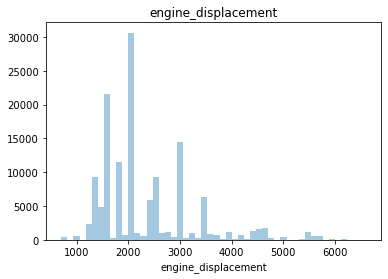

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


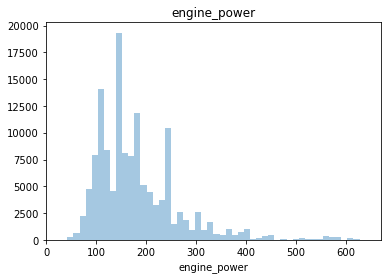

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


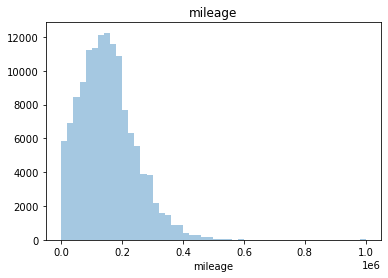

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


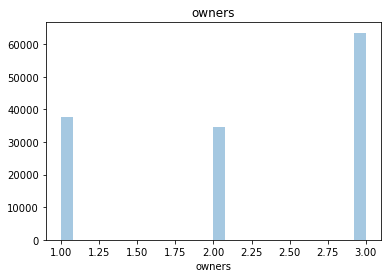

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


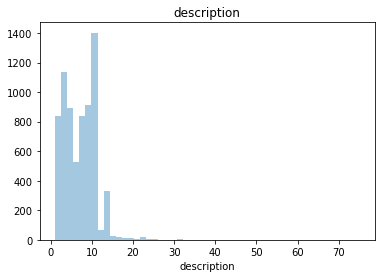

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


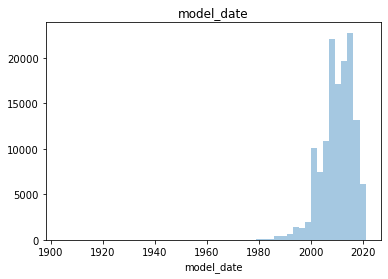

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


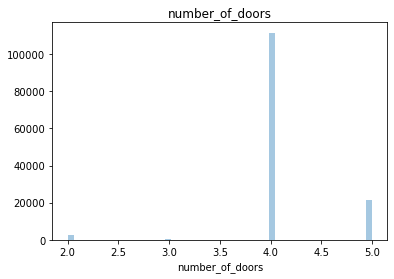

In [5]:
for i in num_cols:
    plt.figure()
    sns.distplot(full_df[i][full_df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Распределение признаков нормальное.

Хотя количество владельцев и выглядит как категоральный признак, оставляем его числовым, т.к. количество владельцев явно влияет на цену автомобиля.

Количество дверей перенесём в категориальные признаки.

In [6]:
num_cols.remove('number_of_doors')
cat_cols.append('number_of_doors')

#### Попробуем прологарифмировать колонки и проверим распределение на копии датафрейма

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


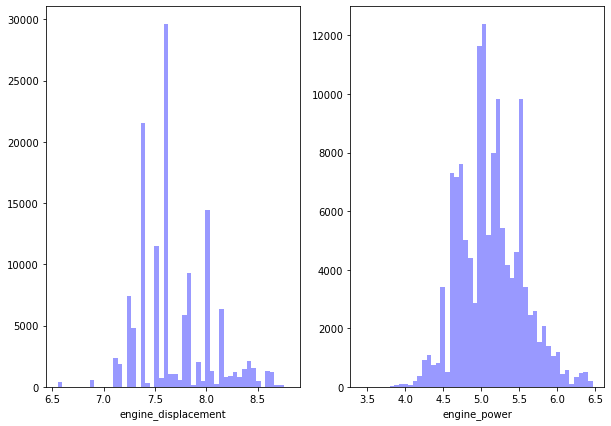

In [7]:
full_df_copy = full_df.copy()
cols = ['engine_displacement', 'engine_power']
fig, axes = plt.subplots(1, len(cols), figsize=(10,7))
for i,col in enumerate(cols):
    full_df_copy[col] = np.log(full_df_copy[col] + 1)
    sns.distplot(full_df_copy[col][full_df_copy[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False, color="b")

#### Попробуем взять квадратный корень тех же колонок и проверим распределение на копии датафрейма

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


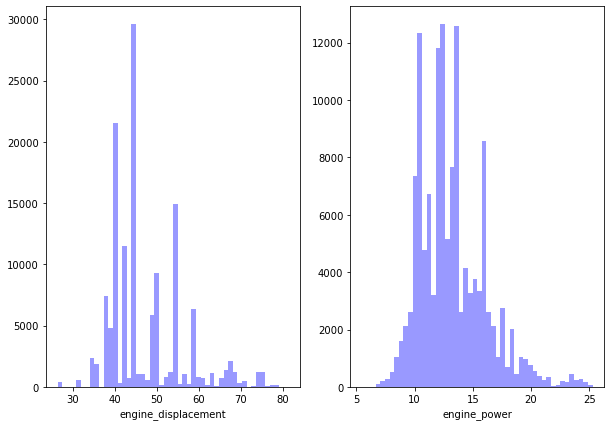

In [8]:
full_df_copy = full_df.copy()
cols = ['engine_displacement', 'engine_power']
fig, axes = plt.subplots(1, len(cols), figsize=(10,7))
for i,col in enumerate(cols):
    full_df_copy[col] = np.sqrt(full_df_copy[col])
    sns.distplot(full_df_copy[col][full_df_copy[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False, color="b")

Логарифмирование признаков улучшает распределение

Прологарифмируем признаки engine_displacement и engine_power

In [9]:
cols = ['engine_displacement', 'engine_power']
for i,col in enumerate(cols):
    full_df[col] = np.log(full_df[col] + 1)

#### Построим boxplot’ы для числовых переменных

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


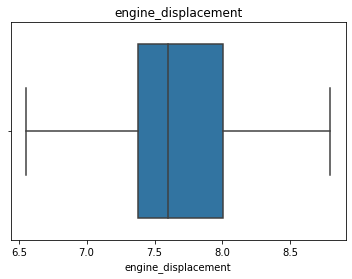

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


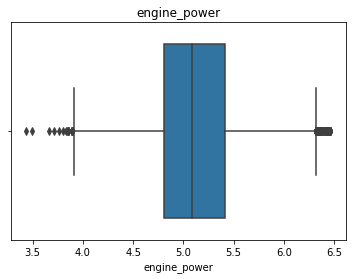

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


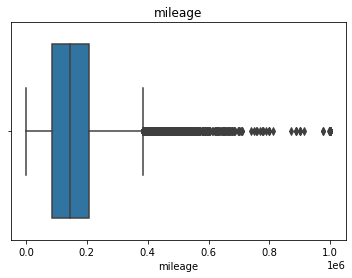

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


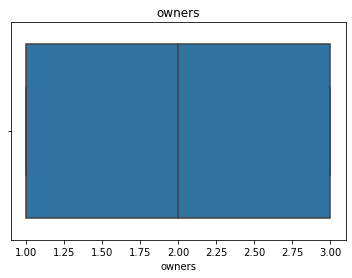

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


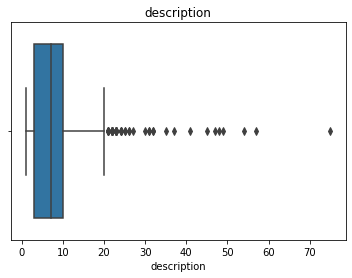

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


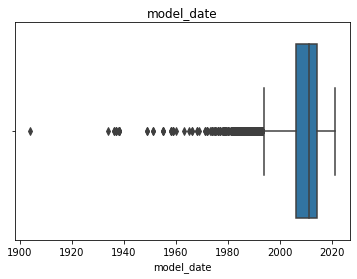

In [10]:
for i in num_cols:
    plt.figure()
    sns.boxplot(full_df[i][full_df[i] > 0].dropna())
    plt.title(i)
    plt.show()

# Обработка выбросов числовых признаков

In [11]:
left, right = get_outliners(full_df['price'])
full_df[((full_df['price'] < left) | (full_df['price'] > right)) & (full_df['test'] == 0)]

Границы выбросов для столбца 'price': [(-1950000.0,), 3250000.0]


,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors
1,7990000,купе,серый,7.313887,5.446737,17979,автоматическая,3,оригинал,левый,bmw,I8,0,2018,0,2
6,5000000,купе,зелёный,8.006701,6.111467,39300,роботизированная,2,оригинал,левый,bmw,M4,0,2017,0,2
11,11300000,седан,серебристый,8.794976,6.413459,15000,автоматическая,1,оригинал,левый,bmw,7ER,0,2019,0,4
12,4499000,внедорожник,серый,8.006701,5.521461,15300,автоматическая,2,оригинал,левый,bmw,X4,0,2019,0,4
15,6250000,седан,чёрный,8.006701,5.521461,16000,автоматическая,1,оригинал,левый,bmw,7ER,0,2020,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101295,3350000,внедорожник,белый,7.601402,5.273000,8000,автоматическая,1,оригинал,левый,mercedes,GLC_KLASSE,0,2020,0,4
101296,4449000,внедорожник,белый,7.601402,5.505332,3630,автоматическая,1,оригинал,левый,mercedes,GLC_KLASSE,0,2020,0,4
101297,6997000,внедорожник,чёрный,8.006701,5.908083,9,автоматическая,1,оригинал,левый,mercedes,GLE_KLASSE,0,2020,0,4
101298,6250000,минивэн,чёрный,7.601402,5.099866,18150,автоматическая,1,оригинал,левый,mercedes,V_KLASSE,11,2020,0,5


In [12]:
left, right = get_outliners(full_df['engine_power'])
full_df[((full_df['engine_power'] < left) | (full_df['engine_power'] > right)) & (full_df['test'] == 0)]

Границы выбросов для столбца 'engine_power': [(3.9063102851244125,), 6.321974472452425]


,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors
5,2499992,седан,синий,8.389587,6.329721,111111,роботизированная,3,дубликат,левый,bmw,M5,0,2012,0,4
11,11300000,седан,серебристый,8.794976,6.413459,15000,автоматическая,1,оригинал,левый,bmw,7ER,0,2019,0,4
16,9000000,седан,коричневый,8.794976,6.415097,13605,автоматическая,1,оригинал,левый,bmw,7ER,0,2018,0,4
21,5742730,седан,коричневый,8.794976,6.415097,78160,автоматическая,1,оригинал,левый,bmw,7ER,0,2017,0,4
46,5553000,седан,чёрный,8.794976,6.415097,33738,автоматическая,3,оригинал,левый,bmw,7ER,0,2017,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101227,16800000,внедорожник,белый,8.294300,6.418365,5,автоматическая,1,оригинал,левый,mercedes,GLS_KLASSE_AMG,0,2020,0,4
101253,18400000,внедорожник,чёрный,8.294300,6.373320,10185,автоматическая,1,оригинал,левый,mercedes,G_KLASSE_AMG,0,2020,0,4
101266,13777000,лифтбек,серый,8.294300,6.461468,1873,роботизированная,1,оригинал,левый,mercedes,AMG_GT,0,2020,0,4
101280,14699000,внедорожник,чёрный,8.294300,6.418365,1691,автоматическая,1,оригинал,левый,mercedes,GLS_KLASSE_AMG,1,2020,0,4


In [13]:
left, right = get_outliners(full_df['mileage'])
full_df[((full_df['mileage'] < left) | (full_df['mileage'] > right)) & (full_df['test'] == 0)]

Границы выбросов для столбца 'mileage': [(-91500.0,), 384500.0]


,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors
0,95000,седан,пурпурный,7.496097,4.736198,385000,механическая,3,дубликат,левый,bmw,3ER,9,1992,0,4
67,945000,седан,чёрный,8.389587,5.659482,420000,автоматическая,3,дубликат,левый,bmw,7ER,0,2001,0,4
74,380000,внедорожник,серебристый,8.006701,5.446737,420000,автоматическая,3,дубликат,левый,bmw,X5,0,2001,0,4
77,400000,седан,серый,7.972811,5.267858,385000,автоматическая,2,дубликат,левый,bmw,5ER,0,2001,0,4
78,370000,седан,чёрный,7.696667,5.141664,400000,автоматическая,3,дубликат,левый,bmw,5ER,0,2001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93013,710000,минивэн,синий,7.696667,5.017280,430000,механическая,3,оригинал,левый,mercedes,VITO,0,2009,0,5
93082,920000,универсал,чёрный,7.696667,5.141664,450000,автоматическая,3,оригинал,левый,mercedes,E_KLASSE,0,2009,0,4
93586,888000,купе-хардтоп,чёрный,7.496097,5.220356,888000,автоматическая,2,дубликат,левый,mercedes,E_KLASSE,0,2010,0,4
93857,900000,минивэн,бежевый,7.650169,4.919981,394000,механическая,2,оригинал,левый,mercedes,VITO,0,2011,0,5


In [14]:
left, right = get_outliners(full_df['model_date'])
full_df[((full_df['model_date'] < left) | (full_df['model_date'] > right)) & (full_df['test'] == 0)]

Границы выбросов для столбца 'model_date': [(1994.0,), 2026.0]


,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors
0,95000,седан,пурпурный,7.496097,4.736198,385000,механическая,3,дубликат,левый,bmw,3ER,9,1992,0,4
55,500000,седан,синий,7.601402,4.867534,350001,механическая,3,оригинал,левый,bmw,5ER,0,1986,0,4
24917,550000,седан,красный,8.412055,5.631212,278000,автоматическая,3,дубликат,левый,infiniti,Q,0,1993,0,4
25607,290000,седан,бежевый,8.412055,5.631212,150386,автоматическая,3,оригинал,левый,infiniti,Q,0,1990,0,4
25940,530000,седан,чёрный,8.412055,5.631212,160000,автоматическая,3,дубликат,левый,infiniti,Q,0,1993,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79836,245000,седан,синий,8.006701,5.361292,777000,автоматическая,1,дубликат,левый,lexus,GS,0,1993,0,4
79943,370000,купе,красный,8.294300,5.505332,250000,автоматическая,3,оригинал,левый,lexus,SC,0,1992,0,2
80029,280000,седан,зелёный,8.294300,5.505332,280000,автоматическая,3,оригинал,левый,lexus,LS,0,1991,0,4
82236,280000,седан,зелёный,8.006701,5.424950,420000,автоматическая,3,дубликат,левый,lexus,GS,0,1993,0,4


In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135986 entries, 0 to 135985
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 135986 non-null  int64  
 1   body_type             135986 non-null  object 
 2   color                 135986 non-null  object 
 3   engine_displacement   135986 non-null  float64
 4   engine_power          135986 non-null  float64
 5   mileage               135986 non-null  int64  
 6   vehicle_transmission  135986 non-null  object 
 7   owners                135986 non-null  int64  
 8   vehicle_pasport       135986 non-null  object 
 9   wheel                 135986 non-null  object 
 10  brand                 135986 non-null  object 
 11  model_name            135986 non-null  object 
 12  description           135986 non-null  int64  
 13  model_date            135986 non-null  int64  
 14  test                  135986 non-null  int64  
 15  

Явно видны выбросы на всех признаках, но они связаны с присутствием редких и дорогих моделей. Мы не будем от них отказываться, т.к. хотелось бы, чтобы модель умела предсказывать и их стоимость.
Выбросы по дате модели находятся в тестовой выборке, так что их тоже не будем трогать.
Тем не менее мы обучали модели на очищенной от выбросов выборке, но это не дало прироста качества моделей.

### Оценка корреляции числовых признаков

<AxesSubplot:>

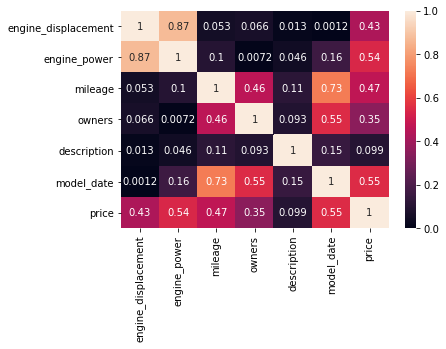

In [16]:
cols = num_cols.copy()
cols.append('price')
sns.heatmap(full_df[full_df['test']==0][cols].corr().abs(), vmin=0, vmax=1, annot=True)

Мы видим сильную корреляцию всех признаков с целевым. 

Так же присутствует сильная корреляция между датой выпуска, пробегом и количеством владельцев, что и понятно.

### Оценим значимость числовых признаков

Посмотрим на коэффициент корреляции Пирсона между признаками и целевой переменной.

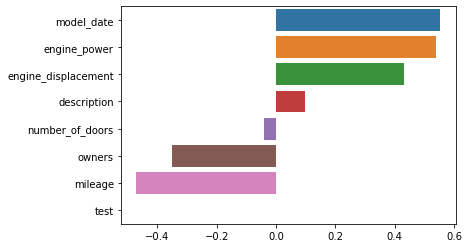

In [17]:
X_train = full_df[full_df['test']==0].drop('price', axis = 1)
y_train = full_df[full_df['test']==0]['price']
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)

График подтверждает реальную ситуацию: количество владельцев и пробег отрицательно влияют на стоимость автомобиля, а мощность, объем двигателя и более поздняя дата выпуска увеличивают ее.

#### Добавим новые признаки возведя в квадрат пробег, объем двигателя и его мощность для того, что бы усилить не линейное влияние этих признаков при обучении модели.

In [18]:
for col in ['engine_displacement','engine_power','mileage']:
    name = col + '_x2'
    full_df[name] = full_df[col].pow(2)
    num_cols.append(name)

еще раз оценим корреляцию

<AxesSubplot:>

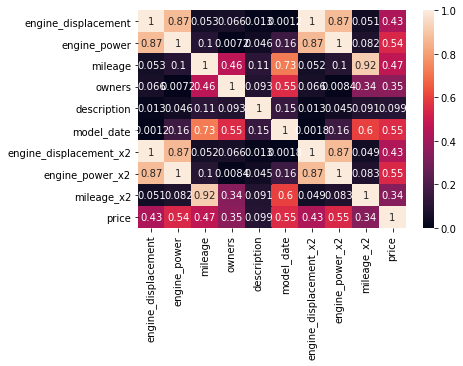

In [19]:
cols = num_cols.copy()
cols.append('price')
sns.heatmap(full_df[full_df['test']==0][cols].corr().abs(), vmin=0, vmax=1, annot=True)

In [20]:
full_df.sample(2)

,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors,engine_displacement_x2,engine_power_x2,mileage_x2
24079,470000,хэтчбек,серебристый,6.552508,3.912023,51000,вариатор,1,оригинал,правый,nissan,DAYZ,0,2018,0,4,42.935360,15.303924,2601000000
94026,1350000,седан,белый,8.455531,6.077642,200000,автоматическая,2,оригинал,левый,mercedes,S_KLASSE,0,2011,0,4,71.495997,36.937735,40000000000


### Исследуем категориальные признаки

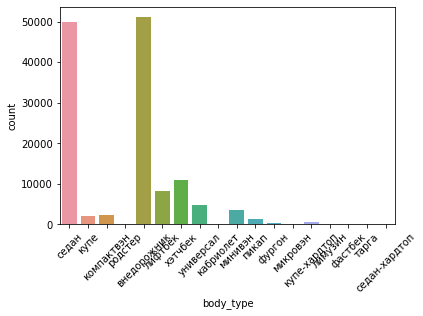

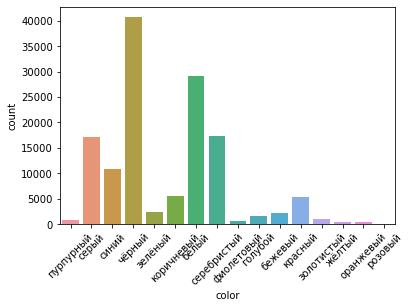

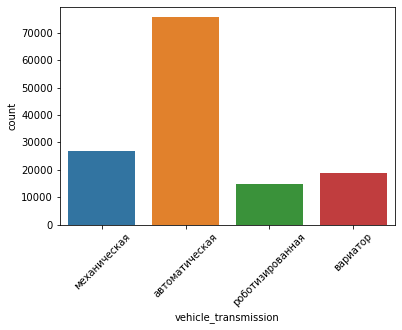

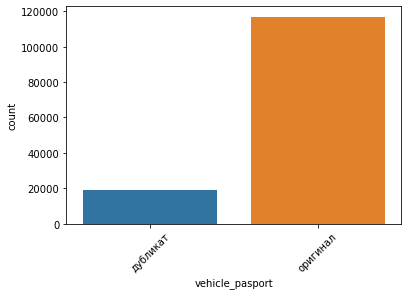

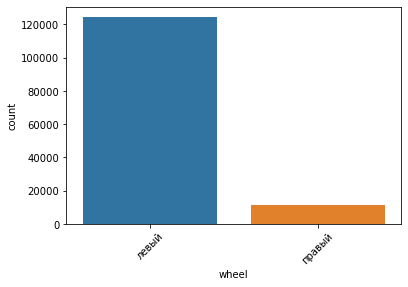

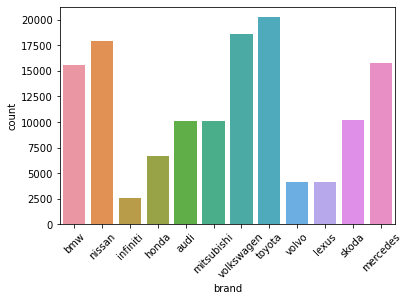

In [21]:
for col in ['body_type','color','vehicle_transmission','vehicle_pasport','wheel','brand']:
    ax = sns.countplot(x=col, data=full_df)
    ax.xaxis.set_tick_params(rotation=45)
    plt.show()

In [22]:
full_df[cat_cols].sample(2)

,body_type,color,vehicle_transmission,vehicle_pasport,wheel,brand,model_name,number_of_doors
88891,лифтбек,белый,роботизированная,оригинал,левый,skoda,OCTAVIA,4
134526,внедорожник,белый,автоматическая,оригинал,левый,toyota,RAV_4,5


In [23]:
full_df.model_name.value_counts()

OCTAVIA         4895
POLO            4147
CAMRY           3814
5ER             3249
E_KLASSE        3205
                ... 
M1                 1
W188               1
V90                1
MEGA_CRUISER       1
GS_F               1
Name: model_name, Length: 624, dtype: int64

Очень большое количество значений имеет имя модели.

Всвязи с большим разнообразием наименований моделей, преобразуем их.

1% наименее используемый обозначим как имя бренда.

In [24]:
model_lst = []
for brand in full_df['brand'].unique():
    count_brand = full_df[full_df['brand'] == brand]['price'].count()
    for model in full_df[full_df['brand'] == brand]['model_name'].unique():
        count_model = full_df[full_df['model_name'] == model]['price'].count()
        if count_model/count_brand < 0.01:
            model_lst.append(model)

for model in model_lst:
    try:
        full_df.loc[full_df['model_name'] == model, 'model_name'] = full_df[full_df['model_name'] == model]['brand'].unique()[0]
    except:
        pass           

In [25]:
full_df.model_name.value_counts()

OCTAVIA     4895
toyota      4685
POLO        4147
CAMRY       3814
5ER         3249
            ... 
infiniti      47
Q70           44
V70           42
XC40          41
QX4           30
Name: model_name, Length: 170, dtype: int64

Теперь количество моделей стало более приемлемым.

#### Для оценки значимости категориальных признаков, преобразуем их в числовые значения.

Для начала используем LabelEncoder для преобразования категориальных признаков в числовые значения, предварительно скопировав в новый датафрейм.

In [26]:
df_copy = full_df[full_df['test']==0][cat_cols + target_cols]

label_encoder = LabelEncoder()

for column in cat_cols:
    df_copy[column] = label_encoder.fit_transform(df_copy[column])
    
# убедимся в преобразовании    
df_copy.sample(2)

,body_type,color,vehicle_transmission,vehicle_pasport,wheel,brand,model_name,number_of_doors,price
29102,0,12,2,1,0,2,39,1,920000
3942,0,15,0,1,0,1,145,1,930000


#### Оценим значимость категориальных признаков

<AxesSubplot:>

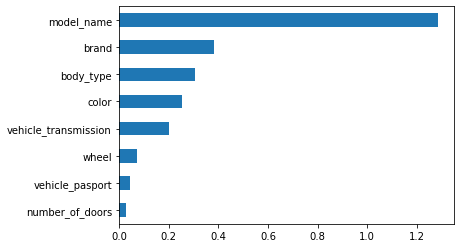

In [27]:
X_train = df_copy.drop('price', axis = 1)
y_train = df_copy['price']

imp_cat = pd.Series(mutual_info_classif(X_train, y_train,\
                    discrete_features = True), index = X_train.columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наибольшее влияние на стоимость оказывают модель, брэнд, тип кузова, цвет и тип привода.

### Машинное обучение

#### Преобразуем категоральные признаки в отдельные признаки.

In [28]:
dummies = pd.get_dummies(full_df[cat_cols])
full_df = full_df.drop(cat_cols, axis=1).join(dummies)
full_df.sample(3)

,price,engine_displacement,engine_power,mileage,owners,description,model_date,test,engine_displacement_x2,engine_power_x2,mileage_x2,number_of_doors,body_type_внедорожник,body_type_кабриолет,body_type_компактвэн,body_type_купе,body_type_купе-хардтоп,body_type_лимузин,body_type_лифтбек,body_type_микровэн,body_type_минивэн,body_type_пикап,body_type_родстер,body_type_седан,body_type_седан-хардтоп,body_type_тарга,body_type_универсал,body_type_фастбек,body_type_фургон,body_type_хэтчбек,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,vehicle_transmission_автоматическая,vehicle_transmission_вариатор,vehicle_transmission_механическая,vehicle_transmission_роботизированная,vehicle_pasport_дубликат,vehicle_pasport_оригинал,wheel_левый,wheel_правый,brand_audi,brand_bmw,brand_honda,brand_infiniti,brand_lexus,brand_mercedes,brand_mitsubishi,brand_nissan,brand_skoda,brand_toyota,brand_volkswagen,brand_volvo,model_name_100,model_name_1ER,model_name_3ER,model_name_4,model_name_5ER,model_name_6ER,model_name_740,model_name_7ER,model_name_80,model_name_850,model_name_940,model_name_960,model_name_A1,model_name_A3,model_name_A4,model_name_A5,model_name_A6,model_name_A7,model_name_A8,model_name_ACCORD,model_name_ALLROAD,model_name_ALMERA,model_name_ALMERA_CLASSIC,model_name_AMAROK,model_name_ASX,model_name_AURIS,model_name_AVENSIS,model_name_A_KLASSE,model_name_B_KLASSE,model_name_C30,model_name_CADDY,model_name_CAMRY,model_name_CARAVELLE,model_name_CARISMA,model_name_CIVIC,model_name_CIVIC_FERIO,model_name_CLA_KLASSE,model_name_CLS_KLASSE,model_name_COLT,model_name_COROLLA,model_name_CR_V,model_name_C_KLASSE,model_name_ES,model_name_EX,model_name_E_KLASSE,model_name_FABIA,model_name_FIT,model_name_FREED,model_name_FX,model_name_G35,model_name_GALANT,model_name_GLA_CLASS,model_name_GLC_KLASSE,model_name_GLE_KLASSE,model_name_GLE_KLASSE_COUPE,model_name_GLK_KLASSE,model_name_GLS_KLASSE,model_name_GL_KLASSE,model_name_GOLF,model_name_GOLF_PLUS,model_name_GS,model_name_GX,model_name_G_KLASSE,model_name_G_KLASSE_AMG,model_name_HIGHLANDER,model_name_HILUX,model_name_HR_V,model_name_IS,model_name_JAZZ,model_name_JETTA,model_name_JUKE,model_name_JX,model_name_KODIAQ,model_name_L200,model_name_LANCER,model_name_LAND_CRUISER,model_name_LAND_CRUISER_PRADO,model_name_LS,model_name_LX,model_name_M,model_name_MARCH,model_name_MAXIMA,model_name_MICRA,model_name_MULTIVAN,model_name_MURANO,model_name_M_KLASSE,model_name_NOTE,model_name_NX,model_name_OCTAVIA,model_name_ODYSSEY,model_name_ORTHIA,model_name_OUTLANDER,model_name_PAJERO,model_name_PAJERO_SPORT,model_name_PASSAT,model_name_PASSAT_CC,model_name_PATHFINDER,model_name_PATROL,model_name_PILOT,model_name_POLO,model_name_PRIMERA,model_name_PRIUS,model_name_Q3,model_name_Q5,model_name_Q50,model_name_Q7,model_name_Q70,model_name_QASHQAI,model_name_QX4,model_name_QX50,model_name_QX56,model_name_QX60,model_name_QX70,model_name_QX80,model_name_RAPID,model_name_RAV_4,model_name_ROOMSTER,model_name_RX,model_name_S40,model_name_S60,model_name_S80,model_name_S90,model_name_SERENA,model_name_SHUTTLE,model_name_STEPWAGON,model_name_STREAM,model_name_SUNNY,model_name_SUPERB,model_name_S_KLASSE,model_name_S_KLASSE_AMG,model_name_TEANA,model_name_TERRANO,model_name_TIGUAN,model_name_TIIDA,model_name_TORNEO,model_name_TOUAREG,model_name_TOURAN,model_name_TRANSPORTER,model_name_TT,model_name_V40,model_name_V40_CC,model_name_V70,model_name_VIANO,model_name_VITO,model_name_VITZ,model_name_V_KLASSE,model_name_X1,model_name_X3,model_name_X4,model_name_X5,model_name_X6,model_name_X6_M,model_name_XC40,model_name_XC60,model_name_XC70,model_name_XC90,model_name_X_TRAIL,model_name_YETI,model_name_audi,model_name_bmw,model_name_honda,model_name_infiniti,model_name_lexus,model_name_mercedes,model_name_mitsubishi,model_name_nissan,model_name_skoda,model_n

#### Разделим обучающую выборку для обучения

In [29]:
X = full_df[full_df['test']==0].drop(['price'], axis = 1)
X = X.drop('test', axis = 1)
y = full_df[full_df['test']==0]['price'].values

test_df = full_df[full_df['test'] == 1].drop(['test','price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

#### Проведем стандартизацию числовых признаков, предварительно отделив тестовую и обучающую выборку.

In [30]:
scaller = StandardScaler()

X_train_transformed = X_train.copy()
X_train_transformed[num_cols] = scaller.fit_transform(X_train_transformed[num_cols])

X_test_transformed = X_test.copy()
X_test_transformed[num_cols] = scaller.transform(X_test_transformed[num_cols])

test_df_transformed = test_df.copy()
test_df_transformed[num_cols] = scaller.transform(test_df_transformed[num_cols])

y_train_log = np.log(y_train+1)


# Выборка, включающая все спарсиные данные. Будем применять ее для обучения перед submission
X_transformed = X.copy()
X_transformed[num_cols] = scaller.transform(X_transformed[num_cols])

y_log = np.log(y+1)

##### Результаты будем сохранять в словаре results

In [31]:
results = {}
version = 0

#### Построим линейную регрессию с целой и логарифмированой целевой переменной

Комментируем все модели, представив их результаты.

In [32]:
'''
lr = LinearRegression()
print ('Исследуем линейную регрессию');
version = 1

mape = learn_model(lr, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(lr, X_test_transformed, test_df_transformed)
safe_results(results, 'LinearRegression', mape, predict_test, predict_submission)
make_submission(predict_submission, version)


print ('Исследуем линейную регрессию с логарифмированием целевой переменной');
version = 2

mape = learn_model(lr, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(lr, X_test_transformed, test_df_transformed, True)
safe_results(results, 'LinearRegression_log', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 50.98%
# kagle 226916

# с логарифмированием целевой переменной
# Средняя абсолютная ошибка в процентах: 15.24%
# kagle 258490

"\nlr = LinearRegression()\nprint ('Исследуем линейную регрессию');\nversion = 1\n\nmape = learn_model(lr, X_transformed, X_test_transformed, y, y_test)\npredict_test, predict_submission = model_prediction(lr, X_test_transformed, test_df_transformed)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'LinearRegression', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n\n\nprint ('Исследуем линейную регрессию с логарифмированием целевой переменной');\nversion = 2\n\nmape = learn_model(lr, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(lr, X_test_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'LinearRegression_log', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

Как и ожидалось, линейная регрессия абсолютно не справляется с задачей, всвязи с тем, что изменение цены нелинейно.

#### Обучим модель на стандартных настройках логистической регрессии.

In [33]:
'''
print ('Исследуем логистическую регрессию');
version = 3

logreg = LogisticRegression(max_iter=100)

mape = learn_model(logreg, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(logreg, X_test_transformed, test_df_transformed)
safe_results(results, 'LogisticRegression', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 17.65%
# kagle 36.53207

"\nprint ('Исследуем логистическую регрессию');\nversion = 3\n\nlogreg = LogisticRegression(max_iter=100)\n\nmape = learn_model(logreg, X_transformed, X_test_transformed, y, y_test)\npredict_test, predict_submission = model_prediction(logreg, X_test_transformed, test_df_transformed)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'LogisticRegression', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Попробуем случайный лес

In [34]:
'''
print ('Исследуем случайный лес');
version = 4

rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)

mape = learn_model(rf, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(rf, X_test_transformed, test_df_transformed)
safe_results(results, 'LogisticRegression', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 3.08%
# kagle 26.11943

'''
print ('Исследуем случайный лес с логарифмированием целевой переменной');
version = 5

mape = learn_model(rf, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(rf, X_test_transformed, test_df_transformed, True)
safe_results(results, 'LogisticRegression_log', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 2.93%
# kagle 19.03580

"\nprint ('Исследуем случайный лес с логарифмированием целевой переменной');\nversion = 5\n\nmape = learn_model(rf, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(rf, X_test_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'LogisticRegression_log', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Подберем параметры для случайного леса

In [35]:
'''
parameters = {'n_estimators': [200, 1100, 2000],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 60, 110],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestRegressor(random_state=RANDOM_SEED)
random_grid = RandomizedSearchCV(estimator=rf, param_distributions=parameters, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
                               '''

"\nparameters = {'n_estimators': [200, 1100, 2000],\n               'max_features': ['auto', 'sqrt'],\n               'max_depth': [10, 60, 110],\n               'min_samples_split': [2, 5, 10],\n               'min_samples_leaf': [1, 2, 4],\n               'bootstrap': [True, False]}\n\nrf = RandomForestRegressor(random_state=RANDOM_SEED)\nrandom_grid = RandomizedSearchCV(estimator=rf, param_distributions=parameters, n_iter=100, \n                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)\n                               "

In [36]:
'''
print ('Исследуем случайный лес с гипер параметрами');
version = 6

est = random_grid.best_estimator_
rf_random = RandomForestRegressor(n_estimators=est.n_estimators, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=25, bootstrap=True, random_state=RANDOM_SEED)

mape = learn_model(rf_random, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(rf_random, X_test_transformed, test_df_transformed, True)
safe_results(results, 'RandomForestRegressor_HP', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

"\nprint ('Исследуем случайный лес с гипер параметрами');\nversion = 6\n\nest = random_grid.best_estimator_\nrf_random = RandomForestRegressor(n_estimators=est.n_estimators, min_samples_split=2, min_samples_leaf=1, \n                             max_features=3, max_depth=25, bootstrap=True, random_state=RANDOM_SEED)\n\nmape = learn_model(rf_random, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(rf_random, X_test_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'RandomForestRegressor_HP', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

Ни одна из наших машин не смогла прогнать RandomizedSearchCV

#### Попробуем ExtraTreesRegressor

In [37]:
'''
print ('Исследуем ExtraTreesRegressor с подбором гиперпараметров');
version = 7
parameters = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
              'max_depth' : [3, 5, 7, 10, 15, None],
              'min_samples_split' : [2, 4, 6],
              'bootstrap' : [True, False]
             }

etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr_grid = RandomizedSearchCV(estimator = etr,
                        param_distributions = parameters, 
                        cv = 3, 
                        verbose=2)
mape = learn_model(etr_grid, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(xgb_grid, X_test_transformed, test_df_transformed, True)
safe_results(results, 'ExtraTreesRegressorHP', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 2.84%
# kagle - 19.9

"\nprint ('Исследуем ExtraTreesRegressor с подбором гиперпараметров');\nversion = 7\nparameters = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],\n              'max_depth' : [3, 5, 7, 10, 15, None],\n              'min_samples_split' : [2, 4, 6],\n              'bootstrap' : [True, False]\n             }\n\netr = ExtraTreesRegressor(random_state=RANDOM_SEED)\netr_grid = RandomizedSearchCV(estimator = etr,\n                        param_distributions = parameters, \n                        cv = 3, \n                        verbose=2)\nmape = learn_model(etr_grid, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(xgb_grid, X_test_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'ExtraTreesRegressorHP', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

### Бустинг

#### Попробуем градиентный бустинг 

In [38]:
'''
print ('Исследуем GradientBoosting');
version = 10

gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)

mape = learn_model(gb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(xb, X_transformed, test_df_transformed, True)
safe_results(results, 'GradientBoostingRegressor', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 7.26%
# kagle 20.21

"\nprint ('Исследуем GradientBoosting');\nversion = 10\n\ngb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)\n\nmape = learn_model(gb, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(xb, X_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'GradientBoostingRegressor', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Попробуем XGBRegressor с L1 regularization

In [39]:
'''
print ('Исследуем XGBRegressor с alpha=1.5 (L1 regularization)');
version = 11

xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, reg_alpha=1.5, n_jobs=-1, n_estimators=500)

mape = learn_model(xb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(xb, X_transformed, test_df_transformed, True)
safe_results(results, 'XGBRegressorL1', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 7.96%
# kagle 18.5

"\nprint ('Исследуем XGBRegressor с alpha=1.5 (L1 regularization)');\nversion = 11\n\nxb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03,                       max_depth=12, reg_alpha=1.5, n_jobs=-1, n_estimators=500)\n\nmape = learn_model(xb, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(xb, X_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'XGBRegressorL1', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

Заметно что дополнительные признаки оказывают положительное влияние

#### Попробуем XGBRegressor с L2 regularization

In [40]:
'''
print ('Исследуем XGBRegressor с lambda=1.5 (L2 regularization)');
version = 12

xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, reg_lambda=1.5, n_jobs=-1, n_estimators=500)
mape = learn_model(xb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(xb, X_test_transformed, test_df_transformed, True)
safe_results(results, 'XGBRegressorL2', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 7.25%
# kagle 18.81

"\nprint ('Исследуем XGBRegressor с lambda=1.5 (L2 regularization)');\nversion = 12\n\nxb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03,                       max_depth=12, reg_lambda=1.5, n_jobs=-1, n_estimators=500)\nmape = learn_model(xb, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(xb, X_test_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'XGBRegressorL2', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Попробуем CatBoostRegressor

In [41]:
'''
from catboost import CatBoostRegressor
print ('Исследуем CatBoostRegressor')
version = 13

cbr = CatBoostRegressor(iterations=5000, learning_rate=1, depth=2, random_seed=RANDOM_SEED)

mape = learn_model(cbr, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(cbr, X_transformed, test_df_transformed, True)
safe_results(results, 'CatBoostRegressor', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 9.94%
# kagle 28.33416

"\nfrom catboost import CatBoostRegressor\nprint ('Исследуем CatBoostRegressor')\nversion = 13\n\ncbr = CatBoostRegressor(iterations=5000, learning_rate=1, depth=2, random_seed=RANDOM_SEED)\n\nmape = learn_model(cbr, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(cbr, X_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'CatBoostRegressor', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Подберем параметры для CatBoostRegressor

In [42]:
# Уже подобранные значения ниже:

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# cbr = CatBoostRegressor(iterations=100, learning_rate=1, depth=2, random_seed=RANDOM_SEED)
# grid_search_result = cbr.grid_search(grid, X=X_transformed, y=y_log, plot=True)

Лучшими параметрами выбраны: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [43]:
# grid_search_result
# {'params': {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

Результат модели с лучшими параметрами

In [44]:
'''
print ('Исследуем CatBoostRegressor с параметрами GridSearch')
version = 14

cbr = CatBoostRegressor(iterations=2000,
                        learning_rate=0.1,
                        depth=10,
                        l2_leaf_reg=1,
                        random_seed=RANDOM_SEED)

mape = learn_model(cbr, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(cbr, X_transformed, test_df_transformed, True)
safe_results(results, 'CatBoostRegressor_GS', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 7.99%
# kagle 21.29833

"\nprint ('Исследуем CatBoostRegressor с параметрами GridSearch')\nversion = 14\n\ncbr = CatBoostRegressor(iterations=2000,\n                        learning_rate=0.1,\n                        depth=10,\n                        l2_leaf_reg=1,\n                        random_seed=RANDOM_SEED)\n\nmape = learn_model(cbr, X_transformed, X_test_transformed, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(cbr, X_transformed, test_df_transformed, True)\npredict_submission = predict_submission * rate_coeff\nsafe_results(results, 'CatBoostRegressor_GS', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

**Примечение**

Дополнительно, чтобы улучшить качество моделей, мы пытались разделить все автомобили на 2 части (дорогие и дешевые). Для разделения использовали признак 'engine_power'. Обучали и предсказывали отдельно по каждому датасету. Результат соединяли в единый файл submission. Но в итоге значимого прироста качества не получили, поэтому далее представлен код для единого датасета

In [45]:
# cheap = full_df[full_df['engine_power'] <= 250]
# expensive = full_df[full_df['engine_power'] > 250]
# expensive.to_csv(path_or_buf=f'{TEST_DATA}expensive.csv')
# cheap.to_csv(path_or_buf=f'{TEST_DATA}cheap.csv')

### Стекинг

#### Функции

In [46]:
# рассчёт алгоритма
def compute_meta_feature(regr, X_train, X_test, y_train, test_df, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    print (splits)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(test_df)

    return X_meta_train, X_meta_test, X_meta_pred

# рассчёт набора алгоритмов
def generate_meta_features(regr, X_train, X_test, y_train, test_df, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, test_df, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack([features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred


#### Список моделей для стэкинга

In [47]:
# выбраем наиболее успешные модели
models = [
RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
ExtraTreesRegressor(n_estimators=300, 
                    criterion='mse', 
                    bootstrap=True, 
                    n_jobs=-1, 
                    random_state=RANDOM_SEED
            ),
XGBRegressor(objective='reg:squarederror', 
                    n_estimators=300,
                    colsample_bytree=0.5, 
                    learning_rate=0.03,
                    max_depth=12, 
                    reg_alpha=1.5, 
                    n_jobs=-1
            ),
XGBRegressor(objective='reg:squarederror', 
                    n_estimators=300,
                    colsample_bytree=0.5, 
                    learning_rate=0.03,
                    max_depth=12, 
                    reg_lambda=1.5, 
                    n_jobs=-1
            )
]

##### Проведем обучение базовых моделей

In [48]:
'''
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(models
    , X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)
'''

'\ncv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)\n\nstacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(models\n    , X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)\n'

#### Проведем обучение мета модели

Попробуем линейную регрессию в качестве мета модели

In [49]:
'''
print ('Исследуем линейную регрессию');
version = 20

lr = LinearRegression()
mape = learn_model(lr, stacked_features_train, stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(lr, stacked_features_test, stacked_features_pred, True)
safe_results(results, 'Stacking', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 4.65%
# kagle 18.58

"\nprint ('Исследуем линейную регрессию');\nversion = 20\n\nlr = LinearRegression()\nmape = learn_model(lr, stacked_features_train, stacked_features_test, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(lr, stacked_features_test, stacked_features_pred, True)\nsafe_results(results, 'Stacking', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

Попробуем случайный лес в качестве мета модели

In [50]:
'''
print ('Исследуем случайный лес');
version = 21

rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
mape = learn_model(rf, stacked_features_train, stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(rf, stacked_features_test, stacked_features_pred, True)
safe_results(results, 'Stacking', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 5.23%
# kagle 19.52

"\nprint ('Исследуем случайный лес');\nversion = 21\n\nrf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)\nmape = learn_model(rf, stacked_features_train, stacked_features_test, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(rf, stacked_features_test, stacked_features_pred, True)\nsafe_results(results, 'Stacking', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

#### Попробуем другой состав стекинга

In [51]:
'''
models = [
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
    ExtraTreesRegressor(n_estimators=200, min_samples_split=2,
                        max_depth=None, bootstrap=True)
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(
    models, X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)

print('Исследуем линейную регрессию')
version = 22

lr = LinearRegression()
mape = learn_model(lr, stacked_features_train,
                   stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    lr, stacked_features_test, stacked_features_pred, True)
safe_results(results, 'Stacking', mape, predict_test, predict_submission)
make_submission(predict_submission, version)
'''

# Средняя абсолютная ошибка в процентах: 2.85%
# kagle 18.77

"\nmodels = [\n    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),\n    ExtraTreesRegressor(n_estimators=200, min_samples_split=2,\n                        max_depth=None, bootstrap=True)\n]\n\ncv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)\n\nstacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(\n    models, X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)\n\nprint('Исследуем линейную регрессию')\nversion = 22\n\nlr = LinearRegression()\nmape = learn_model(lr, stacked_features_train,\n                   stacked_features_test, y_log, y_test, True)\npredict_test, predict_submission = model_prediction(\n    lr, stacked_features_test, stacked_features_pred, True)\nsafe_results(results, 'Stacking', mape, predict_test, predict_submission)\nmake_submission(predict_submission, version)\n"

In [52]:
'''
models = [
RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1),
ExtraTreesRegressor(n_estimators=300, 
                    criterion='mse', 
                    bootstrap=True, 
                    n_jobs=-1, 
                    random_state=RANDOM_SEED
            ),
XGBRegressor(objective='reg:squarederror', 
                    n_estimators=300,
                    colsample_bytree=0.5, 
                    learning_rate=0.03,
                    max_depth=12, 
                    reg_alpha=1.5, 
                    n_jobs=-1
            ),
KNeighborsRegressor(algorithm = 'brute', weights = 'distance', p=1
            )
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(models
    , X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)
'''

# Средняя абсолютная ошибка в процентах: 6.44%
# kagle 19.06

"\nmodels = [\nRandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1),\nExtraTreesRegressor(n_estimators=300, \n                    criterion='mse', \n                    bootstrap=True, \n                    n_jobs=-1, \n                    random_state=RANDOM_SEED\n            ),\nXGBRegressor(objective='reg:squarederror', \n                    n_estimators=300,\n                    colsample_bytree=0.5, \n                    learning_rate=0.03,\n                    max_depth=12, \n                    reg_alpha=1.5, \n                    n_jobs=-1\n            ),\nKNeighborsRegressor(algorithm = 'brute', weights = 'distance', p=1\n            )\n]\n\ncv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)\n\nstacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(models\n    , X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)\n"

## Результат работы:

По результатам обучения различных моделей, наилучший результат показала XGBRegressor с параметром reg_lambda=1.5

В работе удалось создать модель, которая предсказывает стоимость автомобиля по его характеристикам. Эту модель можно использовать для выявления выгодных предложений, когда желаемая цена продавца ниже предсказанной рыночной цены.

В ходе создания модели было сделано:
1. Составлен train датасет из данных с сайта auto.ru
2. На этих данных обучена модель
3. Дополнительно извлечены и сгенерированы новые признаки, в том числе с учетом изменения курса валюты
4. Подобрана оптимальные параметры модели
5. Попроботано большое количество разных алгоритмов и библиотек ML
6. Реализован Stacking

## Выводы:

Сильное различие в метриках на обучаемом и тестовом датасете могут быть связаны с различным периодом парсинга данных.

Большинство моделей (исключая линейную регрессию) показали близкие результаты. Дальнейшее улучшение прогноза можно попытаться достичь за счет подбора гипер параметров.

К сожалению, ни один из компьютеров не смог выполнить полный подбор гипер параметров за разумное время. В связи с этим заметно переобучение на обучаемом датасете.